<a href="https://colab.research.google.com/github/LaurentTits/AI_execices/blob/main/2022_10_20_Defi1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Matériel : vérifier que le GPU est bien sélectionné (A COMPLETER)**

In [1]:
!nvidia-smi
!rm -rf sample_data

Wed Oct 26 17:14:35 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   49C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **2. Importation des librairies**

In [15]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


#**3. Téléchargement des données d'entrainement "Small Dataset"**

In [3]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [4]:
!rm -rf sample_data
! wget --no-check-certificate https://download.smartappli.eu/small.tar
! tar xf small.tar -C 'bases' --one-top-level
! rm small.tar

--2022-10-26 17:14:48--  https://download.smartappli.eu/small.tar
Resolving download.smartappli.eu (download.smartappli.eu)... 46.105.57.169, 2001:41d0:301::20
Connecting to download.smartappli.eu (download.smartappli.eu)|46.105.57.169|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 491589120 (469M) [application/x-tar]
Saving to: ‘small.tar’

small.tar           100%[===================>] 468.82M  20.0MB/s    in 24s     

2022-10-26 17:15:13 (19.2 MB/s) - ‘small.tar’ saved [491589120/491589120]



#**4. Téléchargement des données de test "Test Dataset"**

In [5]:
!rm -rf sample_data
!wget --no-check-certificate http://195.154.53.219/downloads/test.tar
! tar xf test.tar -C 'bases' --one-top-level
! rm test.tar

--2022-10-26 17:15:17--  http://195.154.53.219/downloads/test.tar
Connecting to 195.154.53.219:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 58196480 (56M) [application/octet-stream]
Saving to: ‘test.tar’

test.tar            100%[===================>]  55.50M  15.9MB/s    in 3.5s    

2022-10-26 17:15:21 (15.9 MB/s) - ‘test.tar’ saved [58196480/58196480]



#**5. Création du fichier de labels "classes.txt"**

In [6]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**6. Paramètres d'entrainement et sélection du modèle pré-entrainé**

In [7]:
nb_classes = 3
batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
epochs=5 #@param [5, 10,20,50,100,200] {type:"raw"}
dataset_path = "bases"
input_dim=299 #@param [224,299] {type:"raw"}  
dataset_name='small' #@param ["small","DB1","DB2","DB3"]
train_dataset = os.path.join('bases/', dataset_name)
test_name='test' #@param ["test","test1","test2","test3"]
test_dataset = os.path.join('bases/', test_name)
classes_path = "classes.txt"
classifier = "Xception" #@param ["Xception","VGG16","VGG19","ResNet50","ResNet121","ResNet152","ResNet50V2","ResNet121V2","ResNet152V2","InceptionV3","InceptionResNetV2","MobileNet","MobileNetV2","DenseNet121","DenseNet169","DenseNet201","NASNetLarge","NASNetMobile"] {type:"string"}


# **7. Compter le nombre de classes**

In [8]:
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Création du jeu de données d'entraînement  (A COMPLETER)**

In [9]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="training",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
	batch_size=batch_size,   # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 791 files belonging to 3 classes.
Using 633 files for training.


#**9. Créer le jeu de validation (A COMPLETER : même générateur, One-Hot, jeu "validation")**

In [10]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	train_dataset,               # chemin vers le jeu de données
	validation_split=0.2,        # paritionnement du jeu de données en un jeu de validation (20%), train (80%)
	subset="validation",           # Sélection du jeu de données d'entraînement
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
	batch_size=batch_size,   # Taille du mini-batch
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 791 files belonging to 3 classes.
Using 158 files for validation.


# **10. Télécharger un modèle préentraîné et appliquer le Transfer Learning**



In [11]:
base_model = Xception(include_top=False, weights='imagenet', input_shape = (input_dim, input_dim, 3))
#create a custom top classifier
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(nb_classes, activation = 'softmax')(x)
model = Model(inputs=base_model.inputs, outputs=predictions)


83683744/83683744 [==============================] - 0s 0us/step


In [ ]:
print(model.summary())

# **11. Geler puis dégeler les poids des premières couches**

In [ ]:
base_model.trainable = False
print(model.summary())
base_model.trainable = True

# **11. Compiler le modèle avec la descente de gradient stochastique DSG**


In [14]:
# recompiler le modèle
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

# **12. Entraîner le modèle**

In [16]:
base_model.trainable = False

stopper = EarlyStopping(monitor='val_loss', min_delta=0, patience=100, 
                        verbose=1, mode='auto')
ckpt_save = os.path.join(".",'model_fine_ep{epoch}_valloss{val_loss:.3f}.h5')

checkpoint = ModelCheckpoint(ckpt_save, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='auto')

callback_list = [checkpoint, stopper]

history = model.fit(train_ds, validation_data = val_ds, batch_size = batch_size, 
                    epochs=epochs, callbacks=callback_list)




Epoch 1/5
80/80 [==============================] - ETA: 0s - loss: 0.7828 - accuracy: 0.6840
Epoch 1: val_loss improved from inf to 0.60052, saving model to ./model_fine_ep1_valloss0.601.h5
80/80 [==============================] - 43s 349ms/step - loss: 0.7828 - accuracy: 0.6840 - val_loss: 0.6005 - val_accuracy: 0.8481
Epoch 2/5
80/80 [==============================] - ETA: 0s - loss: 0.3857 - accuracy: 0.9084
Epoch 2: val_loss improved from 0.60052 to 0.30755, saving model to ./model_fine_ep2_valloss0.308.h5
80/80 [==============================] - 28s 330ms/step - loss: 0.3857 - accuracy: 0.9084 - val_loss: 0.3075 - val_accuracy: 0.9051
Epoch 3/5
80/80 [==============================] - ETA: 0s - loss: 0.2317 - accuracy: 0.9305
Epoch 3: val_loss improved from 0.30755 to 0.22796, saving model to ./model_fine_ep3_valloss0.228.h5
80/80 [==============================] - 28s 337ms/step - loss: 0.2317 - accuracy: 0.9305 - val_loss: 0.2280 - val_accuracy: 0.8987
Epoch 4/5
80/80 [=========

#**13. Sauvegarder le modèle final (A COMPLETER)**


In [17]:
# checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

#model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
#    filepath=checkpoint_filepath,
#    monitor='val_accuracy',
#    mode='max',
#    save_best_only=True)

#history = model.fit(train_ds, validation_data = val_ds, batch_size = batch_size, 
#                    epochs=epochs, callbacks=[model_checkpoint_callback])

model.save('models/firstmodel')


In [18]:
saved_model = keras.models.load_model('models/firstmodel')


In [19]:
first_model = keras.models.load_model('model_fine_ep5_valloss0.218.h5')

#**14. Afficher des courbes d'entrainement/validation**

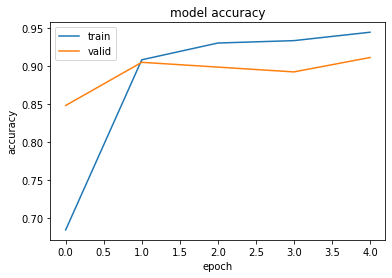

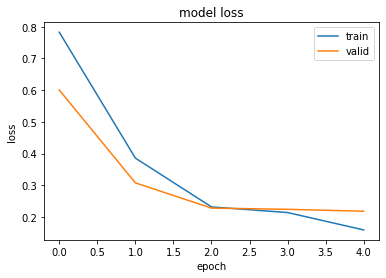

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')

plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper right')

plt.show()

# **15. Créer le jeu de données de test**

In [21]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
	test_dataset,               # chemin vers le jeu de données
	seed=42,                     # Initialisation du générateur aléatoire (permutations)
	image_size=(input_dim, input_dim),   # Taille des images d'entrée
  batch_size=batch_size,   # not useful for test_ds
  label_mode='categorical'    # Conversion au format One-Hot
)

Found 210 files belonging to 3 classes.


# **16. Evaluer le modèle avec ce jeu de données de test**

In [22]:
score = model.evaluate(test_ds)
print('score', score[0], score[1])

27/27 [==============================] - 3s 90ms/step - loss: 0.4542 - accuracy: 0.8000
score 0.4541512727737427 0.800000011920929


In [23]:
score = first_model.evaluate(test_ds)
print('score', score[0], score[1])

27/27 [==============================] - 3s 79ms/step - loss: 0.4542 - accuracy: 0.8000
score 0.4541512727737427 0.800000011920929


#**16. Tester le modèle avec une image de test: "fire.jpg" et "no_fire.jpg (A COMPLETER)"**

In [ ]:
files.upload()

1/1 [==============================] - 1s 677ms/step
Class Name : fire --- Class Probability: 93.94%
Class Name : no_fire --- Class Probability: 2.18%
Class Name : start_fire --- Class Probability: 3.88%


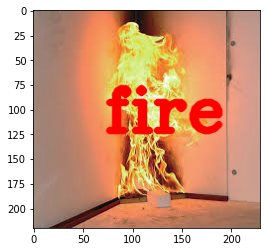

In [25]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 0s 20ms/step
Class Name : fire --- Class Probability: 0.28%
Class Name : no_fire --- Class Probability: 94.07%
Class Name : start_fire --- Class Probability: 5.65%


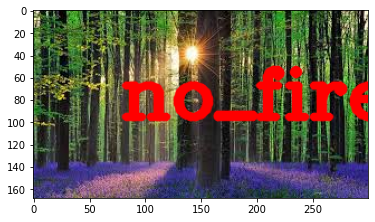

In [27]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "no_fire.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 0s 20ms/step
Class Name : fire --- Class Probability: 14.68%
Class Name : no_fire --- Class Probability: 1.49%
Class Name : start_fire --- Class Probability: 83.84%


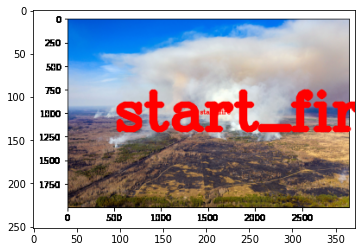

In [29]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "start_fire.png"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [ ]:
files.upload()

1/1 [==============================] - 1s 652ms/step
Class Name : fire --- Class Probability: 58.87%
Class Name : no_fire --- Class Probability: 18.43%
Class Name : start_fire --- Class Probability: 22.71%


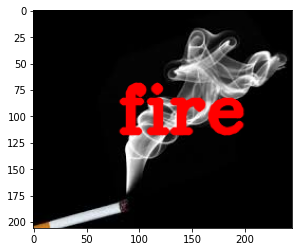

In [31]:
%matplotlib inline

classes = train_ds.class_names
image_path =  "smoke_cigaret.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = first_model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()

In [32]:
from matplotlib import pyplot as plt
import numpy as np
import os
import cv2 
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, GlobalAveragePooling2D, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
from PIL import Image
from google.colab import files
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


In [33]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt
classes_path = "classes.txt"
# Récupérer les noms des classes
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

In [35]:
first_model = keras.models.load_model('model_fine_ep5_valloss0.218.h5')

In [ ]:
files.upload()

1/1 [==============================] - 1s 667ms/step
Class Name : fire --- Class Probability: 58.87%
Class Name : no_fire --- Class Probability: 18.43%
Class Name : start_fire --- Class Probability: 22.71%


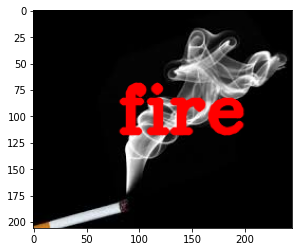

In [37]:
%matplotlib inline

image_path =  "smoke_cigaret.jpg"

img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)

# predict
pred = first_model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    #print("Top %d ====================" % (i + 1))
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()